In [1]:
# Импорт библиотек
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as pyplot
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import AllChem
from rdkit.Chem import Crippen
from rdkit import rdBase, DataStructs
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import random
from math import sqrt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD,RMSprop
from tensorflow.keras import initializers
from keras import backend as K
# Считывание датасета из файла
DATA_PATH = 'UIRS/'
df = pd.read_csv("delaney_processed.csv")
PandasTools.AddMoleculeColumnToFrame(df,'smiles','molec')
LogP_list=[]
for i in range(len(df[['molec']])):
    mol = Chem.Crippen.MolLogP(df.loc[i,'molec'])
    LogP_list.append(mol)
df['LogP'] = LogP_list

**Общие операции**

In [2]:
# Функция разделения датасета на тестовую и тренировочную выборку
def Razdelit_Dataset(dataframe):
    train_df = df.sample(frac=.8, random_state=43)
    test_df = df[~df.index.isin(train_df.index)]
    return train_df, test_df


In [3]:
def m_f(dataframe,k,n):
    MF_list=[]
    for i in range(len(dataframe[['molec']])):
      mol = AllChem.GetMorganFingerprintAsBitVect((dataframe.loc[i,'molec']), k, nBits=n)
      MF_list.append(mol)
    MF_ar = np.asanyarray(MF_list)
    return pd.DataFrame(MF_ar)
k=2


In [4]:
# Подготовка входных данных
def df_in_ndar(train_df, test_df):
    independ = 'Number of Rotatable Bonds'
    independ1 = 'Molecular Weight'
    independ2 = 'LogP'
    independ3 = 'Number of Rings'
    independ4 = 'Polar Surface Area'
    independ5 = 'Number of H-Bond Donors'
    
    depend = 'measured log solubility in mols per litre'
    test_y = np.asanyarray(test_df[[depend]])
    test_x = np.asanyarray(test_df[[independ,independ1,independ2,independ3,independ4,independ5]])
    train_y = np.asanyarray(train_df[[depend]])
    train_x = np.asanyarray(train_df[[independ,independ1,independ2,independ3,independ4,independ5]])
    return train_x, train_y, test_x, test_y


In [5]:
# Вызов функций
train_df, test_df=Razdelit_Dataset(df)
train_x, train_y, test_x, test_y = df_in_ndar(train_df,test_df)

**Случайный лес**

28


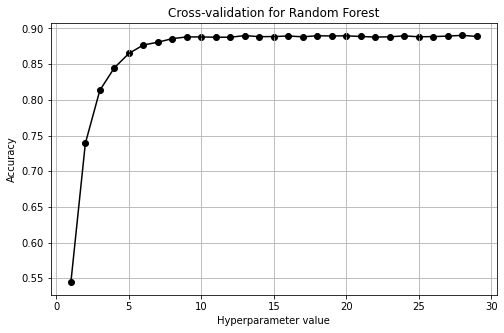

In [122]:
# Составление функции подбора параметров случайного леса
def cross_validation_RF(train_x, train_y, test_x, test_y):
    best_score=0
    best_param=0
    score_arr=[]
    param_arr=[]
    for i in range(1,30, 1):
        der = RandomForestRegressor(max_depth=i)
        scores=cross_val_score(der, train_x, train_y.ravel(), cv=10)
        score_arr.append(scores.mean())
        param_arr.append(i)
        if best_score < scores.mean():
            best_score = scores.mean()
            best_param = i
    print(best_param)
    plt.figure(figsize=(8,5))
    plt.scatter(param_arr,score_arr,color='black')
    plt.plot(param_arr,score_arr,color='black')
    plt.xlabel('Hyperparameter value')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.title('Cross-validation for Random Forest')
    plt.show()
    return best_param
best_param_RF = cross_validation_RF(train_x, train_y, test_x, test_y)

In [123]:
# Функция для реализации случайного леса
def random_forest(train_x, train_y, test_x, test_y, best_param_RF):
    les = RandomForestRegressor(max_depth=14)
    les.fit(train_x, train_y.ravel())
    test_Y_ = les.predict(test_x)
    return test_Y_
test_Y_RF = random_forest(train_x, train_y, test_x, test_y, best_param_RF)

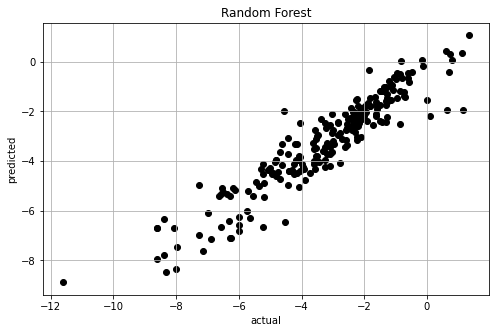

0.775692947529279


In [124]:
# Отрисовка результата случанйого леса
def plot(test_Y_, str_title):
    plt.figure(figsize=(8,5))
    plt.scatter(test_y,test_Y_,color='black')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.grid()
    plt.title(str_title)
    plt.show()
    return print(sqrt(mean_squared_error(test_y,test_Y_)))
plot(test_Y_RF, "Random Forest")

**Градиентный бустинг**

58


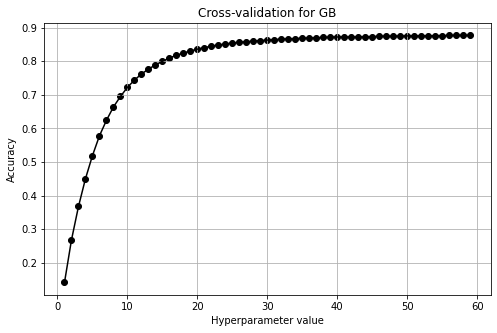

In [129]:
# Составление функции для подбора параметров градиентного бустинга
def cross_validation_RF(train_x, train_y, test_x, test_y):
    best_score=0
    best_param=0
    score_arr=[]
    param_arr=[]
    for i in range(1, 60, 1):
        der = GradientBoostingRegressor(n_estimators=i)
        scores=cross_val_score(der, train_x, train_y.ravel(), cv=10)
        score_arr.append(scores.mean())
        param_arr.append(i)
        if best_score < scores.mean():
            best_score = scores.mean()
            best_param = i
    print(best_param)
    plt.figure(figsize=(8,5))
    plt.scatter(param_arr,score_arr,color='black')
    plt.plot(param_arr,score_arr,color='black')
    plt.xlabel('Hyperparameter value')
    plt.ylabel('Accuracy')
    plt.grid()
    plt.title('Cross-validation for GB')
    plt.show()
    return best_param
best_param_Gb = cross_validation_RF(train_x, train_y, test_x, test_y)

In [167]:
# Функция реализации градиентного бустинга
def Gboost(train_x, train_y, test_x, test_y):
    gboost = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1)
    gboost.fit(train_x, train_y.ravel())
    test_Y_ = gboost.predict(test_x)
    return test_Y_
test_Y_Gb = Gboost(train_x, train_y, test_x, test_y)

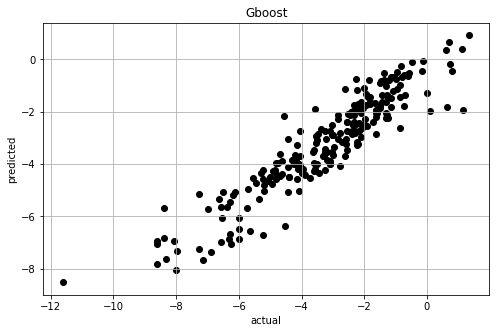

0.8109997990622536


In [168]:
# Отрисовка результата градиентного бустинга
def plot(test_Y_, str_title):
    plt.figure(figsize=(8,5))
    plt.scatter(test_y,test_Y_,color='black')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.grid()
    plt.title(str_title)
    plt.show()
    return print(sqrt(mean_squared_error(test_y,test_Y_)))
plot(test_Y_Gb, "Gboost")

**Нейронная сеть через керас**

In [169]:

batch_size = 128
epochs = 3000
learning_rate=0.01


def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 



model = keras.Sequential(
    [
        keras.Input(shape=train_x.shape[1]),
        layers.Dense(5, activation="relu"),
        layers.Dense(2, activation="relu"),
        layers.Dense(1)
    ]
)
#load_status = model.load_weights("ckpt")

model.compile(loss=root_mean_squared_error, optimizer='Adam', metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse')])


In [170]:
history = model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose = 0)

In [171]:
score=model.evaluate(test_x,test_y, batch_size=batch_size,)
print('Test loss:',score[0])
print('Test accuracy:',score[1])

2/2 [==============================] - 0s 4ms/step - loss: 2.1855 - rmse: 2.1926
Test loss: 2.185476064682007
Test accuracy: 2.192643642425537


In [141]:
#model.save_weights("ckpt")

In [15]:
# Реализация нейронной сети с помощью Keras. Подбор наиболее эффективного количества нейронов в двух первых слоях перебором с шагом.
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
res = []
batch_size = 128
epochs = 1500

for i in range(8, 33, 8):
    for j in range(8, 33, 8):
        model = keras.Sequential([
                keras.Input(shape=train_x.shape[1]),
                layers.Dense(i, activation="relu"),
                layers.Dense(j, activation="relu"),
                layers.Dense(1)])
        #load_status = model.load_weights("ckpt")
        
        model.compile(loss=root_mean_squared_error, optimizer='Adam', metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse')])
        history = model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose = 0)
        
        score=model.evaluate(test_x,test_y, batch_size=batch_size)
        RMSE_loss = round(score[1], 4)
    
        res_dict = {'Количество нейронов первого слоя': i, 'Количество нейронов второго слоя': j, 'RMSE': RMSE_loss}
        res.append(res_dict)

2/2 [==============================] - 0s 4ms/step - loss: 0.9099 - rmse: 0.9126


In [16]:
res_df = pd.DataFrame(res)

In [17]:
res_df.sort_values('RMSE')

,Количество нейронов первого слоя,Количество нейронов второго слоя,RMSE
13,32,16,0.8749
14,32,24,0.8826
4,16,8,0.8830
8,24,8,0.9103
15,32,32,0.9126
11,24,32,0.9154
2,8,24,0.9173
0,8,8,0.9207
9,24,16,0.9255
3,8,32,0.9357


In [18]:
# Реализация нейронной сети с помощью Keras. Подбор наиболее эффективного количества нейронов в двух первых слоях перебором с шагом с другими значениям.
res_2 = []
batch_size = 128
epochs = 1500

for i in range(33, 129, 32):
    for j in range(17, 65, 16):
        model = keras.Sequential([
                keras.Input(shape=train_x.shape[1]),
                layers.Dense(i, activation="relu"),
                layers.Dense(j, activation="relu"),
                layers.Dense(1)])
        #load_status = model.load_weights("ckpt")
        
        model.compile(loss=root_mean_squared_error, optimizer='Adam', metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse')])
        history = model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose = 0)
        
        score=model.evaluate(test_x,test_y, batch_size=batch_size)
        RMSE_loss = round(score[1], 4)
    
        res_dict = {'Количество нейронов первого слоя': i, 'Количество нейронов второго слоя': j, 'RMSE': RMSE_loss}
        res_2.append(res_dict)

2/2 [==============================] - 0s 4ms/step - loss: 0.8564 - rmse: 0.8632


In [19]:
res_2 = pd.DataFrame(res_2)

In [20]:
res_2.sort_values('RMSE')

,Количество нейронов первого слоя,Количество нейронов второго слоя,RMSE
8,97,49,0.8632
3,65,17,0.9130
5,65,49,0.9229
0,33,17,0.9274
4,65,33,0.9491
2,33,49,0.9538
6,97,17,0.9604
7,97,33,0.9681
1,33,33,0.9741


In [148]:
random.seed(42)
rand_ar = random.sample(range(1, 100),7)
rand_ar.sort()

In [149]:
rand_ar

[4, 15, 29, 32, 36, 82, 95]

In [150]:
# Реализация нейронной сети с помощью Keras. Подбор наиболее эффективного количества нейронов в первом слою с помощью случайного подбора значений.
resultss = []
for num in range(0,len(rand_ar)):
    rand = rand_ar[num]
    model = keras.Sequential([
                keras.Input(shape=train_x.shape[1]),
                layers.Dense(rand, activation="relu"),
                layers.Dense(48, activation="relu"),
                layers.Dense(1)])
        #load_status = model.load_weights("ckpt")  
    model.compile(loss=root_mean_squared_error, optimizer='Adam', metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    history = model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose = 0)
    
    score=model.evaluate(test_x,test_y, batch_size=batch_size)
    RMSE_loss = round(score[1], 4)
    
    res_dict = {'Количество нейронов первого слоя': rand, 'Количество нейронов второго слоя': 48, 'RMSE': RMSE_loss}
    resultss.append(res_dict)

2/2 [==============================] - 0s 4ms/step - loss: 0.9419 - rmse: 0.9419


In [151]:
resultss = pd.DataFrame(resultss)

In [152]:
resultss.sort_values('RMSE')

,Количество нейронов первого слоя,Количество нейронов второго слоя,RMSE
4,36,48,0.8627
3,32,48,0.8833
5,82,48,0.8893
1,15,48,0.9003
0,4,48,0.9060
6,95,48,0.9419
2,29,48,1.0468


In [6]:
random.seed(43)
rand_ar = random.sample(range(1, 100),7)
rand_ar.sort()

In [11]:
# Реализация нейронной сети с помощью Keras. Подбор наиболее эффективного количества нейронов во втором слое с помощью случайного подбора значений.
res11 = []
batch_size = 128
epochs = 1500
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
for num in range(0,len(rand_ar)):
    rand = rand_ar[num]
    model = keras.Sequential([
                keras.Input(shape=train_x.shape[1]),
                layers.Dense(32, activation="relu"),
                layers.Dense(rand, activation="relu"),
                layers.Dense(1)])
        #load_status = model.load_weights("ckpt")  
    model.compile(loss=root_mean_squared_error, optimizer='Adam', metrics = [tf.keras.metrics.RootMeanSquaredError(name='rmse')])
    history = model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, validation_split=0.2, verbose = 0)
    
    score=model.evaluate(test_x,test_y, batch_size=batch_size)
    RMSE_loss = round(score[1], 4)
    
    res_dict11 = {'Количество нейронов первого слоя': rand, 'Количество нейронов второго слоя': 48, 'RMSE': RMSE_loss}
    res11.append(res_dict11)

2/2 [==============================] - 0s 4ms/step - loss: 0.8828 - rmse: 0.8890


In [12]:
res11 = pd.DataFrame(res11)

In [13]:
res11.sort_values('RMSE')

,Количество нейронов первого слоя,Количество нейронов второго слоя,RMSE
5,90,48,0.8250
0,5,48,0.8327
2,37,48,0.8412
4,60,48,0.8820
6,98,48,0.8890
1,19,48,0.8931
3,48,48,0.9222


In [14]:
rand_ar

[5, 19, 37, 48, 60, 90, 98]

In [ ]:
def korrekcia_osveshenia(noon,morning,night,night_light):
    #noon_os = 1 * np.log(noon/float(np.max(noon)) + 1)
    noon_os = (1 * ((np.power(noon/np.max(noon), 2))*255)).astype("uint8")
    
    #morning_os = 2.9 * np.log(morning/float(np.max(morning)) + 1)*255
    morning_os = (((np.power(morning/np.max(morning), 1/2))*255)).astype("uint8")
    
    #night_os = 2.9 * np.log(night/float(np.max(night)) + 1)
    night_os = (((np.power(night/np.max(night), 1/2))*255)).astype("uint8")
    
    #night_light_os = 1.1 * np.log(night_light/float(np.max(night_light)) + 1)
    night_light_os = (1*((np.power(night_light/np.max(night_light), 1/2))*256)).astype("uint8")
    return noon_os, morning_os, night_os, night_light_os